In [0]:
!pip install Pillow==4.1.1
!pip install torch torchvision

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
ls

drive/  sample_data/


In [0]:
cd drive/'My Drive'

/content/drive/My Drive


In [0]:
cd 'Style Transfer'

/content/drive/My Drive/Style Transfer


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms, models

In [0]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:11<00:00, 50710868.61it/s]


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Cuda Available: ', torch.cuda.is_available())
vgg.to(device)

Cuda Available:  True


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(path, max_size=400, shape=None):
    image = Image.open(path).convert('RGB')
    
    if(max(image.size) > max_size):
        size = max_size
    else:
        size = max(image.size)
        
    if(shape is not None):
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return(image)

In [0]:
#load content image
content = load_image('zbyst.jpg').to(device)

In [0]:
# load style image 
style = load_image('kOdFoWHzw.jpeg', shape=content.shape[-2:]).to(device)

In [0]:
#function to convert image from it's normalised form to back to regular form
def imconvert(tensor):
    tensor = tensor.cpu().clone().detach()
    tensor = tensor.numpy().squeeze()
    tensor = tensor.transpose(1,2,0)
    tensor = tensor * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    tensor = tensor.clip(0,1)
    return(tensor)

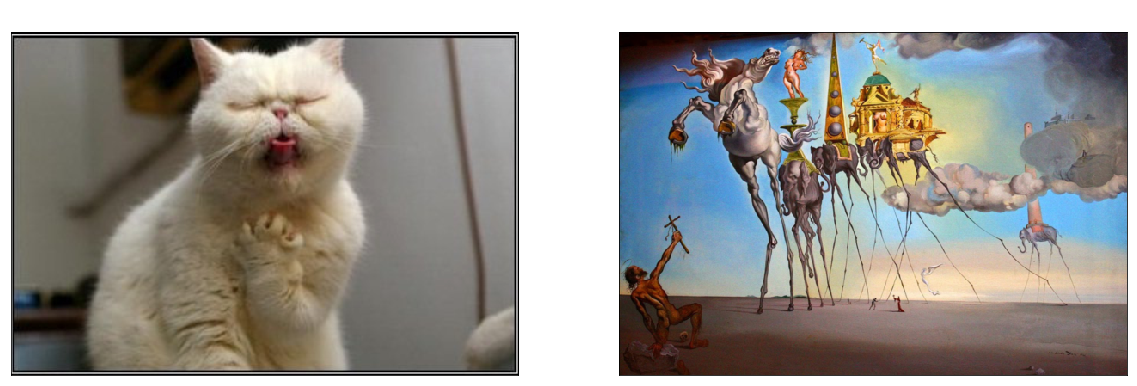

In [0]:
fig = plt.figure(figsize=(20,10));
ax1 = fig.add_subplot(1,2,1, xticks=[], yticks=[]);
ax1.imshow(imconvert(content));
ax1.set_title('Content Image', color='white', size=24);
ax2 = fig.add_subplot(1,2,2, xticks=[], yticks=[]);
ax2.imshow(imconvert(style));
ax2.set_title('Style Image', color='white', size=24);

In [0]:
# show vgg model
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
#defining the function to get layers
def get_features(image, model, layers=None):
    if(layers is None):
        layers = {'0':'conv1_1','5':'conv2_1', '10':'conv3_1', '19':'conv4_1', '28':'conv5_1', '21':'conv4_2'}
    
    features = {}
    for name, layer in model._modules.items():
        image = layer(image)
        if(name in layers):
            features[layers[name]]=image
    
    return(features)

In [0]:
def gram_matrix(tensor):
    batch_size, depth, height, width = tensor.shape
    
    tensor = tensor.view(depth, -1)
    tensor = torch.mm(tensor, tensor.t())
    return(tensor)

In [0]:
style_features = get_features(style, vgg)
content_features = get_features(content, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# start with content image 
target = content.clone().requires_grad_(True).to(device)

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# alpha 
content_weight = 1 
# beta 
style_weight = 5e6 

Total Loss:  44949768.0
Total Loss:  13364051.0
Total Loss:  7902125.5
Total Loss:  5497807.5
Total Loss:  4130251.25
Total Loss:  3280621.25
Total Loss:  2720245.5
Total Loss:  2336078.5
Total Loss:  2059925.25
Total Loss:  1850258.25
Total Loss:  1685365.625
Total Loss:  1551725.875


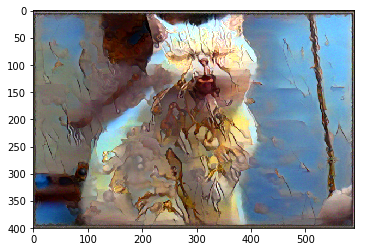

In [0]:

optimizer = torch.optim.Adam([target], lr=0.003)

steps = 2400
print_every = 200

for i in range(1,steps+1):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        
        target_feature = target_features[layer]
        
        _, d, h, w = target_feature.shape
        
        target_gram = gram_matrix(target_feature)
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss/ (d*h*w)
    
    total_loss = style_weight*style_loss + content_weight*content_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if(i%print_every==0):
        print('Total Loss: ', total_loss.item())
        plt.imshow(imconvert(target))

In [0]:
plt.imsave('result1.jpg', imconvert(target))

In [0]:
# round 2
content = load_image('dice.jpg').to(device)
style = load_image('rumors_of_spring.jpg', shape=content.shape[-2:]).to(device)

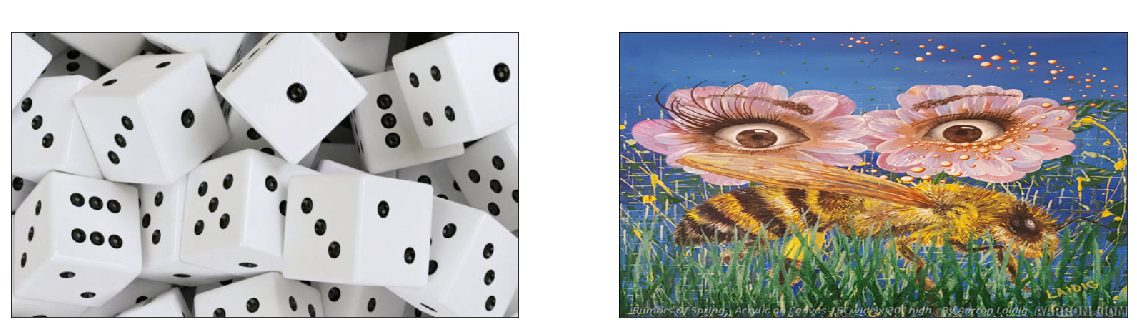

In [0]:
fig = plt.figure(figsize=(20,10));
ax1 = fig.add_subplot(1,2,1, xticks=[], yticks=[]);
ax1.imshow(imconvert(content));
ax1.set_title('Content Image', color='white', size=24);
ax2 = fig.add_subplot(1,2,2, xticks=[], yticks=[]);
ax2.imshow(imconvert(style));
ax2.set_title('Style Image', color='white', size=24);

In [0]:
style_features = get_features(style, vgg)
content_features = get_features(content, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# start with content image 
target = content.clone().requires_grad_(True).to(device)

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# alpha 
content_weight = 1 
# beta 
style_weight = 5e6 

Total Loss:  475780864.0
Total Loss:  327069952.0
Total Loss:  247518176.0
Total Loss:  184236256.0
Total Loss:  130817824.0
Total Loss:  92694728.0
Total Loss:  68307800.0
Total Loss:  51979168.0
Total Loss:  40235460.0
Total Loss:  31433886.0


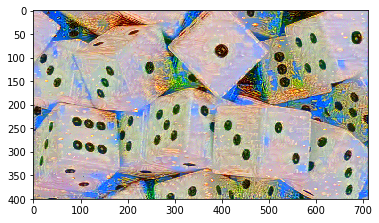

In [0]:
optimizer = torch.optim.Adam([target], lr=0.003)

steps = 3200
print_every = 320

for i in range(1,steps+1):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        
        target_feature = target_features[layer]
        
        _, d, h, w = target_feature.shape
        
        target_gram = gram_matrix(target_feature)
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss/ (d*h*w)
    
    total_loss = style_weight*style_loss + content_weight*content_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if(i%print_every==0):
        print('Total Loss: ', total_loss.item())
        plt.imshow(imconvert(target))

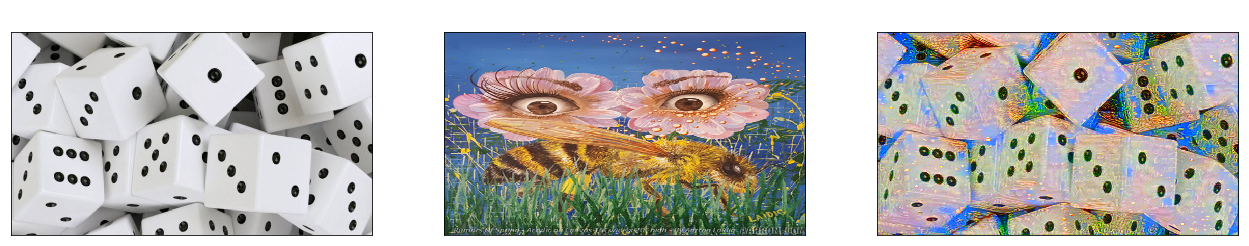

In [0]:
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(1,3,1, xticks=[], yticks=[])
ax1.imshow(imconvert(content))
ax1.set_title('Content', color='white', size=24);
ax2 = fig.add_subplot(1,3,2, xticks=[], yticks=[])
ax2.imshow(imconvert(style))
ax2.set_title('Style', color='white', size=24);
ax3 = fig.add_subplot(1,3,3, xticks=[], yticks=[])
ax3.imshow(imconvert(target))
ax3.set_title('Transfer', color='white', size=24);

In [0]:
plt.imsave('result2.jpg', imconvert(target))